In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/ECE57000_AI/Project

/content/drive/MyDrive/ECE57000_AI/Project


In [4]:
!pwd

/content/drive/MyDrive/ECE57000_AI/Project


In [5]:
!pip install tensorflow==2.8.0
!pip install sionna

  Using cached tensorflow-2.8.0-cp310-cp310-manylinux2010_x86_64.whl.metadata (2.9 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.8.0-cp310-cp310-manylinux2010_x86_64.whl (497.6 MB)
Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 

In [7]:
# Import TensorFlow and NumPy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sionna as sn
%matplotlib inline

In [8]:
print("TensorFlow version:", tf.__version__)
print("Sionna version:", sn.__version__)

TensorFlow version: 2.15.1
Sionna version: 0.19.0


In [9]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available:', len(gpus))

if gpus:
    gpu_num = 0  # Set to 0 to use the first GPU available (if only one GPU is present)
    try:
        # Ensure that `gpu_num` is within the range of available GPUs
        if gpu_num < len(gpus):
            tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
            print('Only GPU number', gpu_num, 'used.')
            tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
        else:
            print(f"GPU number {gpu_num} is out of range. Only {len(gpus)} GPU(s) detected.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs available.")

Number of GPUs available: 1
Only GPU number 0 used.


In [10]:
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, GaussianPriorSource
from sionna.utils import BinarySource, ebnodb2no, BitwiseMutualInformation, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
from sionna.fec.ldpc import LDPCBPDecoder

from tensorflow.keras.layers import Dense, Layer

In [11]:
class E2EModel(tf.keras.Model):
    def __init__(self, pcm, decoder):
        super().__init__()
        self._pcm = pcm
        self._n = pcm.shape[1]
        self._k = self._n - pcm.shape[0]
        self._encoder = LinearEncoder(pcm, is_pcm=True)

        self._binary_source = BinarySource()

        self._num_bits_per_symbol = 2 # at the moment only QPSK is supported
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._channel = AWGN()
        self._decoder = decoder

    @tf.function()
    def call(self, batch_size, ebno_db):

        # calculate noise variance
        if self._decoder is not None:
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._k/self._n)
        else: #for uncoded BPSK the rate is 1
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, 1)

        # draw random info bits to transmit
        b = self._binary_source([batch_size, self._k])
        c = self._encoder(b)

        # zero padding to support odd codeword lengths
        if self._n%2==1:
            c_pad = tf.concat([c, tf.zeros([batch_size, 1])], axis=1)
        else: # no padding
            c_pad = c

        # map to symbols
        x = self._mapper(c_pad)

        # transmit over AWGN channel
        y = self._channel([x, no])

        # demap to LLRs
        llr = self._demapper([y, no])

        # remove filler bits
        if self._n%2==1:
            llr = llr[:,:-1]

        # and decode
        if self._decoder is not None:
            llr = self._decoder(llr)

        return c, llr

In [12]:
# load the parity-check matrix of the code
pcm, k, n, coderate = load_parity_check_examples(pcm_id=1, verbose=True)


n: 63, k: 45, coderate: 0.714


In [13]:
ber_plot = PlotBER("GNN-based Decoding Results")
ebno_db_min = 2.0
ebno_db_max = 9.0
ebno_dbs = np.arange(ebno_db_min,ebno_db_max+1)

mc_iters = 100
mc_batch_size = 10000
num_target_block_errors = 2000

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 3.7425e-02 | 9.0860e-01 |       23578 |      630000 |         9086 |       10000 |         6.3 |reached target block errors
      3.0 | 2.3002e-02 | 7.7040e-01 |       14491 |      630000 |         7704 |       10000 |         0.0 |reached target block errors
      4.0 | 1.2516e-02 | 5.5030e-01 |        7885 |      630000 |         5503 |       10000 |         0.0 |reached target block errors
      5.0 | 5.8302e-03 | 3.0680e-01 |        3673 |      630000 |         3068 |       10000 |         0.0 |reached target block errors
      6.0 | 2.3627e-03 | 1.3800e-01 |        2977 |     1260000 |         2760 |       20000 |         0.0 |reached target block errors
      7.0 | 7.8825e-04 | 4.8520e-02 |        2483 |     3150000 |

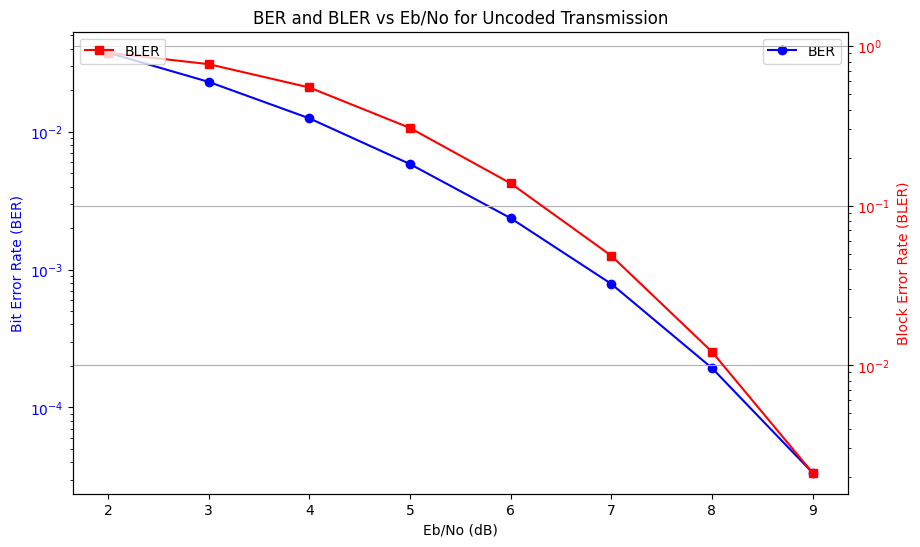

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

e2e_uncoded = E2EModel(pcm, None)
# Run the simulation and capture the returned (ber, bler) tuple
ber, bler = ber_plot.simulate(
    e2e_uncoded,
    ebno_dbs=ebno_dbs,
    batch_size=mc_batch_size,
    num_target_block_errors=num_target_block_errors,
    legend="Uncoded",
    soft_estimates=True,
    max_mc_iter=mc_iters,
    forward_keyboard_interrupt=False,
    show_fig=False
)

# Assuming `ebno_dbs` is a list or array of Eb/No values used in the simulation
# Convert the results to a DataFrame for display
results_df = pd.DataFrame({
    "EbNo [dB]": ebno_dbs,
    "BER": ber,
    "BLER": bler
})

# Plotting BER and BLER vs EbNo in dB
fig, ax1 = plt.subplots(figsize=(10, 6))

# BER Plot
ax1.plot(results_df["EbNo [dB]"], results_df["BER"], 'o-', color='blue', label="BER")
ax1.set_xlabel("Eb/No (dB)")
ax1.set_ylabel("Bit Error Rate (BER)", color="blue")
ax1.set_yscale("log")  # Log scale for BER
ax1.tick_params(axis='y', labelcolor="blue")

# BLER Plot (on the same plot with different y-axis)
ax2 = ax1.twinx()
ax2.plot(results_df["EbNo [dB]"], results_df["BLER"], 's-', color='red', label="BLER")
ax2.set_ylabel("Block Error Rate (BLER)", color="red")
ax2.set_yscale("log")  # Log scale for BLER
ax2.tick_params(axis='y', labelcolor="red")

# Title and Legends
plt.title("BER and BLER vs Eb/No for Uncoded Transmission")
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

plt.grid()
plt.show()

In [12]:
bp_decoder = LDPCBPDecoder(pcm, num_iter=20, hard_out=False)
e2e_bp = E2EModel(pcm, bp_decoder)
ber, bler = ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size,
                  num_target_block_errors=num_target_block_errors,
                  legend=f"BP {e2e_bp._decoder.num_iter.numpy()} iter.",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False);

# Assuming `ebno_dbs` is a list or array of Eb/No values used in the simulation
# Convert the results to a DataFrame for display
results_df = pd.DataFrame({
    "EbNo [dB]": ebno_dbs,
    "BER": ber,
    "BLER": bler
})

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.1254e-02 | 8.0840e-01 |       38590 |      630000 |         8084 |       10000 |         7.9 |reached target block errors
      3.0 | 3.2944e-02 | 4.9200e-01 |       20755 |      630000 |         4920 |       10000 |         0.2 |reached target block errors
      4.0 | 1.3375e-02 | 2.0750e-01 |        8426 |      630000 |         2075 |       10000 |         0.1 |reached target block errors
      5.0 | 4.4190e-03 | 6.2925e-02 |       11136 |     2520000 |         2517 |       40000 |         0.6 |reached target block errors
      6.0 | 9.1935e-04 | 1.2794e-02 |        9267 |    10080000 |         2047 |      160000 |         2.4 |reached target block errors
      7.0 | 1.3527e-04 | 1.8440e-03 |        8522 |    63000000 |

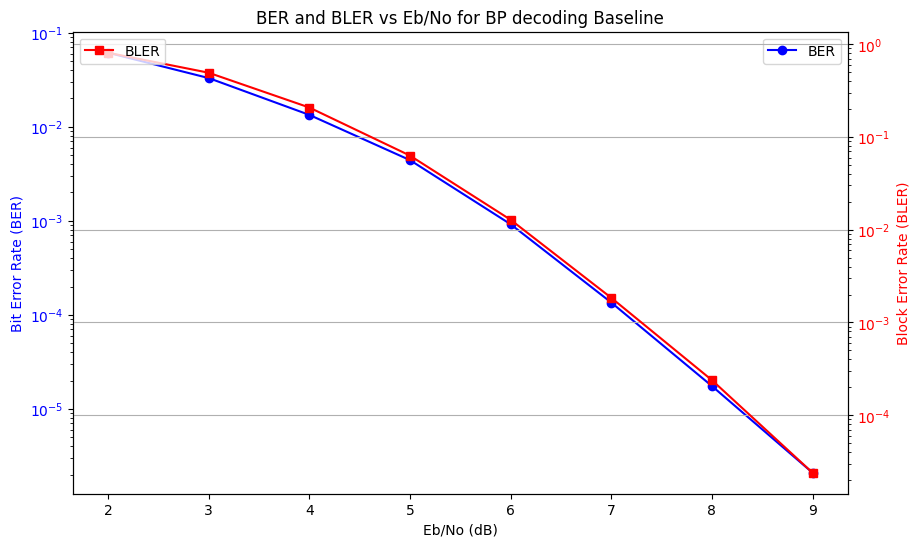

In [13]:
# Plotting BER and BLER vs EbNo in dB
fig, ax1 = plt.subplots(figsize=(10, 6))

# BER Plot
ax1.plot(results_df["EbNo [dB]"], results_df["BER"], 'o-', color='blue', label="BER")
ax1.set_xlabel("Eb/No (dB)")
ax1.set_ylabel("Bit Error Rate (BER)", color="blue")
ax1.set_yscale("log")  # Log scale for BER
ax1.tick_params(axis='y', labelcolor="blue")

# BLER Plot (on the same plot with different y-axis)
ax2 = ax1.twinx()
ax2.plot(results_df["EbNo [dB]"], results_df["BLER"], 's-', color='red', label="BLER")
ax2.set_ylabel("Block Error Rate (BLER)", color="red")
ax2.set_yscale("log")  # Log scale for BLER
ax2.tick_params(axis='y', labelcolor="red")

# Title and Legends
plt.title("BER and BLER vs Eb/No for BP decoding Baseline")
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

plt.grid()
plt.show()

BP decoder can be further optimized by applying the concept of weighted BP

In [15]:
class WeightedBP(tf.keras.Model):
    def __init__(self, pcm, num_iter=5):
        super().__init__()
        # init components
        self.decoder = LDPCBPDecoder(pcm,
                                        num_iter=1, # iterations are done via outer loop (to access intermediate results for multi-loss)
                                        stateful=True,
                                        hard_out=False, # we need to access soft-information
                                        cn_type="boxplus",
                                        trainable=True) # the decoder must be trainable, otherwise no weights are generated

        # used to generate llrs during training (see example notebook on all-zero codeword trick)
        self._llr_source = GaussianPriorSource()
        self._num_iter = num_iter

        self._n = pcm.shape[1]
        self._coderate = 1 - pcm.shape[0]/pcm.shape[1]
        self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):
        #batch_size = tf.constant(batch_size, dtype=tf.int32)
        #ebno_db = tf.constant(ebno_db, dtype=tf.float32)
        noise_var = ebnodb2no(ebno_db,
                                num_bits_per_symbol=2, # QPSK
                                coderate=self._coderate)

        # all-zero CW to calculate loss / BER
        c = tf.zeros([batch_size, self._n])

        # Gaussian LLR source
        llr = self._llr_source([[batch_size, self._n], noise_var])

        # implement multi-loss as proposed by Nachmani et al.
        loss = 0
        msg_vn = None
        for _ in range(self._num_iter):
            c_hat, msg_vn = self.decoder((llr, msg_vn)) # perform one decoding iteration; decoder
            # returns soft-values
            loss += self._bce(c, c_hat)  # add loss after each iteration

        loss /= self._num_iter # scale loss by number of iterations

        return c, c_hat, loss

    def train_wbp(self, train_param):

        assert len(train_param["batch_size"])==len(train_param["train_iter"]),\
                        "batch_size must have same lengths as train_iter"

        assert len(train_param["batch_size"])==\
                len(train_param["learning_rate"]),\
                "batch_size must have same lengths as learning_rate"

        assert len(train_param["batch_size"])==len(train_param["ebno_train"]),\
                        "batch_size must have same lengths as ebno_train"

        # bmi is used as metric to evaluate the intermediate results
        bmi = BitwiseMutualInformation()

        for idx, batch_size in enumerate(train_param["batch_size"]):

            optimizer = tf.keras.optimizers.Adam(train_param["learning_rate"][idx])

            for it in range(train_param["train_iter"][idx]):
                with tf.GradientTape() as tape:
                    b, llr, loss = self(batch_size,
                                        train_param["ebno_train"][idx])

                grads = tape.gradient(loss, self.trainable_variables)
                grads = tf.clip_by_value(grads,
                                            -train_param["clip_value_grad"],
                                            train_param["clip_value_grad"],
                                            name=None)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))

                # calculate and print intermediate metrics
                # only for information, this has no impact on the training
                if it%50==0: # evaluate every 10 iterations
                    b, llr, loss = self(train_param["batch_size_val"],
                                        train_param["ebno_val"])
                    b_hat = hard_decisions(llr) # hard decided LLRs first
                    ber = compute_ber(b, b_hat)
                    # and print results
                    mi = bmi(b, llr).numpy() # calculate bit-wise mutual information
                    l = loss.numpy() # copy loss to numpy for printing
                    print(f"Iter: {it} loss: {l:3f} ber: {ber:.4f} bmi: {mi:.3f}".format())
                    bmi.reset_states() # reset the BMI metric

In [16]:
model_wbp = WeightedBP(pcm=pcm, num_iter=10) # model is only used for training

In [17]:
# generate new decoder object (with 20 iterations)
bp_decoder_wbp = LDPCBPDecoder(pcm, num_iter=20, hard_out=False, trainable=True)

# copy weights from trained decoder
bp_decoder_wbp.set_weights(model_wbp.decoder.get_weights())
e2e_wbp = E2EModel(pcm, bp_decoder_wbp)

# and evaluate the performance
ber, bler = ber_plot.simulate(e2e_wbp,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size*10, #increased bs for higher gpu load
                  num_target_block_errors=num_target_block_errors,
                  legend=f"Weighted BP {e2e_wbp._decoder.num_iter.numpy()} iter.",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False);

# Assuming `ebno_dbs` is a list or array of Eb/No values used in the simulation
# Convert the results to a DataFrame for display
results_df = pd.DataFrame({
    "EbNo [dB]": ebno_dbs,
    "BER": ber,
    "BLER": bler
})

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.0397e-02 | 8.0241e-01 |      380499 |     6300000 |        80241 |      100000 |         6.8 |reached target block errors
      3.0 | 3.2860e-02 | 4.9159e-01 |      207015 |     6300000 |        49159 |      100000 |         1.2 |reached target block errors
      4.0 | 1.3608e-02 | 2.0829e-01 |       85728 |     6300000 |        20829 |      100000 |         1.2 |reached target block errors
      5.0 | 4.3722e-03 | 6.3060e-02 |       27545 |     6300000 |         6306 |      100000 |         1.2 |reached target block errors
      6.0 | 9.6778e-04 | 1.3220e-02 |       12194 |    12600000 |         2644 |      200000 |         2.5 |reached target block errors
      7.0 | 1.4554e-04 | 1.9045e-03 |       10086 |    69300000 |

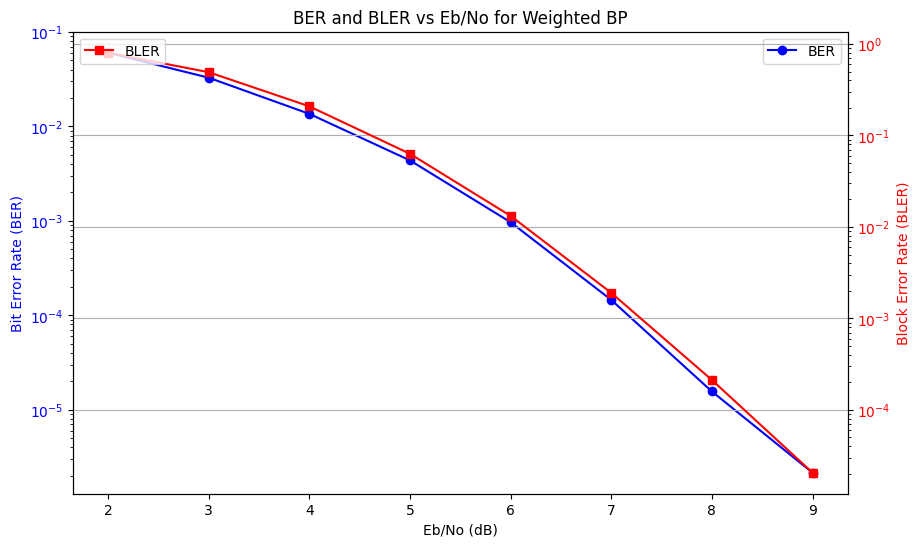

In [18]:
# Plotting BER and BLER vs EbNo in dB
fig, ax1 = plt.subplots(figsize=(10, 6))

# BER Plot
ax1.plot(results_df["EbNo [dB]"], results_df["BER"], 'o-', color='blue', label="BER")
ax1.set_xlabel("Eb/No (dB)")
ax1.set_ylabel("Bit Error Rate (BER)", color="blue")
ax1.set_yscale("log")  # Log scale for BER
ax1.tick_params(axis='y', labelcolor="blue")

# BLER Plot (on the same plot with different y-axis)
ax2 = ax1.twinx()
ax2.plot(results_df["EbNo [dB]"], results_df["BLER"], 's-', color='red', label="BLER")
ax2.set_ylabel("Block Error Rate (BLER)", color="red")
ax2.set_yscale("log")  # Log scale for BLER
ax2.tick_params(axis='y', labelcolor="red")

# Title and Legends
plt.title("BER and BLER vs Eb/No for Weighted BP")
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

plt.grid()
plt.show()

In [19]:
class MLP(Layer):
    def __init__(self, units, activations, use_bias):
        super().__init__()
        self._num_units = units
        self._activations = activations
        self._use_bias = use_bias

    def build(self, input_shape):
        self._layers = []
        for i, units in enumerate(self._num_units):
            self._layers.append(Dense(units,
                                      self._activations[i],
                                      use_bias=self._use_bias[i]))

    def call(self, inputs):
        outputs = inputs
        for layer in self._layers:
            outputs = layer(outputs)
        return outputs

class GNN_BP(Layer):
    def __init__(self,
                 pcm,
                 num_embed_dims,
                 num_msg_dims,
                 num_hidden_units,
                 num_mlp_layers,
                 num_iter,
                 reduce_op="sum",
                 activation="relu",
                 output_all_iter=False,
                 clip_llr_to=None):
        super().__init__()

        self._pcm = pcm # Parity check matrix
        self._num_cn = pcm.shape[0] # Number of check nodes
        self._num_vn = pcm.shape[1] # Number of variables nodes
        self._num_edges = int(np.sum(pcm)) # Number of edges

        # Array of shape [num_edges, 2]
        # 1st col = CN id, 2nd col = VN id
        # The ith row of this array defines the ith edge.
        self._edges = np.stack(np.where(pcm), axis=1)

        # Create 2D ragged tensor of shape [num_cn,...]
        # cn_edges[i] contains the edge ids for CN i
        cn_edges = []
        for i in range(self._num_cn):
            cn_edges.append(np.where(self._edges[:,0]==i)[0])
        self._cn_edges = tf.ragged.constant(cn_edges)

        # Create 2D ragged tensor of shape [num_vn,...]
        # vn_edges[i] contains the edge ids for VN i
        vn_edges = []
        for i in range(self._num_vn):
            vn_edges.append(np.where(self._edges[:,1]==i)[0])
        self._vn_edges = tf.ragged.constant(vn_edges)

        self._num_embed_dims = num_embed_dims # Number of dimensions for vertex embeddings
        self._num_msg_dims = num_msg_dims # Number of dimensions for messages
        self._num_hidden_units = num_hidden_units # Number of hidden units for MLPs computing messages and embeddings
        self._num_mlp_layers = num_mlp_layers # Number of layers for MLPs computing messages and embeddings
        self._num_iter = num_iter # Number of BP iterations, can be modified

        self._reduce_op = reduce_op # reduce operation for message aggregation
        self._activation = activation # activation function of the hidden MLP layers

        self._output_all_iter = output_all_iter
        self._clip_llr_to = clip_llr_to

    @property
    def num_iter(self):
        return self._num_iter

    @num_iter.setter
    def num_iter(self, value):
        self._num_iter = value

    def build(self, input_shape):
        # NN to transform input LLR to VN embedding
        self._llr_embed = Dense(self._num_embed_dims)

        # NN to transform VN embedding to output LLR
        self._llr_inv_embed = Dense(1)

        # CN embedding update function
        self.update_h_cn = UpdateEmbeddings(self._num_msg_dims,
                                            self._num_hidden_units,
                                            self._num_mlp_layers,
                                            np.flip(self._edges, 1), # Flip columns: "from VN to CN"
                                            self._cn_edges,
                                            self._reduce_op,
                                            self._activation)

        # VN embedding update function
        self.update_h_vn = UpdateEmbeddings(self._num_msg_dims,
                                            self._num_hidden_units,
                                            self._num_mlp_layers,
                                            self._edges, # "from CN to VN"
                                            self._vn_edges,
                                            self._reduce_op,
                                            self._activation)

    def llr_to_embed(self, llr):
        """Transform LLRs to VN embeddings"""
        return self._llr_embed(tf.expand_dims(llr, -1))

    def embed_to_llr(self, h_vn):
        """Transform VN embeddings to LLRs"""
        return tf.squeeze(self._llr_inv_embed(h_vn), axis=-1)

    def call(self, llr):
        batch_size = tf.shape(llr)[0]

        # Initialize vertex embeddings
        if self._clip_llr_to is not None:
            llr = tf.clip_by_value(llr, -self._clip_llr_to, self._clip_llr_to)

        h_vn = self.llr_to_embed(llr)
        h_cn = tf.zeros([batch_size, self._num_cn, self._num_embed_dims])

        # BP iterations
        if self._output_all_iter:
            llr_hat = []

        for i in range(self._num_iter):
            # Update CN embeddings
            h_cn = self.update_h_cn(h_vn, h_cn)

            # Update VNs
            h_vn = self.update_h_vn(h_cn, h_vn)

            if self._output_all_iter:
                llr_hat.append(self.embed_to_llr(h_vn))

        if not self._output_all_iter:
            llr_hat = self.embed_to_llr(h_vn)

        return llr_hat

class UpdateEmbeddings(Layer):
    def __init__(self,
                 num_msg_dims,
                 num_hidden_units,
                 num_mlp_layers,
                 from_to_ind,
                 gather_ind,
                 reduce_op="sum",
                 activation="relu",
                 ):
        super().__init__()
        self._num_msg_dims = num_msg_dims
        self._num_hidden_units = num_hidden_units
        self._num_mlp_layers = num_mlp_layers
        self._from_ind = from_to_ind[:,0]
        self._to_ind = from_to_ind[:,1]
        self._gather_ind = gather_ind
        self._reduce_op = reduce_op
        self._activation = activation

    def build(self, input_shape):
        num_embed_dims = input_shape[-1]

        # MLP to compute messages
        units = [self._num_hidden_units]*(self._num_mlp_layers-1) + [self._num_msg_dims]
        activations = [self._activation]*(self._num_mlp_layers-1) + [None]
        use_bias = [True]*self._num_mlp_layers
        self._msg_mlp = MLP(units, activations, use_bias)

        # MLP to update embeddings from accumulated messages
        units[-1] = num_embed_dims
        self._embed_mlp = MLP(units, activations, use_bias)

    def call(self, h_from, h_to):
        # Concatenate embeddings of the transmitting (from) and receiving (to) vertex for each edge
        features = tf.concat([tf.gather(h_from, self._from_ind, axis=1),
                              tf.gather(h_to, self._to_ind, axis=1)],
                             axis=-1)

        # Compute messsages for all edges
        messages = self._msg_mlp(features)

        # Reduce messages at each receiving (to) vertex
        # note: bring batch dim to last dim for improved performance
        # with ragged tensors
        messages = tf.transpose(messages, (1,2,0))
        m_ragged = tf.gather(messages, self._gather_ind, axis=0)
        if self._reduce_op=="sum":
            m = tf.reduce_sum(m_ragged, axis=1)
        elif self._reduce_op=="mean":
            m = tf.reduce_mean(m_ragged, axis=1)
        else:
            raise ValueError("unknown reduce operation")
        m = tf.transpose(m, (2,0,1)) # batch-dim back to first dim

        # Compute new embeddings
        h_to_new = self._embed_mlp(tf.concat([m, h_to], axis=-1))

        return h_to_new

In [21]:
tf.random.set_seed(2)
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=20,
                     num_msg_dims=20,
                     num_hidden_units=40,
                     num_mlp_layers=2,
                     num_iter=8,
                     reduce_op="mean",
                     activation="tanh",
                     output_all_iter=True,
                     clip_llr_to=None)
e2e_gnn = E2EModel(pcm, gnn_decoder)

In [22]:
e2e_gnn(1, 1.) # call model once to init
e2e_gnn.summary()

Model: "e2e_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_encoder_2 (LinearEn  multiple                  0         
 coder)                                                          
                                                                 
 binary_source_2 (BinarySou  multiple                  0         
 rce)                                                            
                                                                 
 mapper_2 (Mapper)           multiple                  0         
                                                                 
 demapper_2 (Demapper)       multiple                  0         
                                                                 
 awgn_2 (AWGN)               multiple                  0         
                                                                 
 gnn_bp (GNN_BP)             multiple                  

total_iterations in original paper  = 35000 + 300000 + 300000 = 635000

To estimate the time for the full training, we will:

1.   Run a shorter version of the training process (20000 iterations).
2.   Record the time taken for these 20000 iterations.
3.   Use this time to estimate the duration for 635000 iterations.








In [28]:
# Define the path for the weights file
weights_file_path = "./e2e_gnn_weights.h5"

# Check for existing weights and load if available
if os.path.exists(weights_file_path):
    print("Loading existing weights...")
    e2e_gnn.load_weights(weights_file_path)
else:
    print("No existing weights found. Starting training from scratch.")

No existing weights found. Starting training from scratch.


In [ ]:
import os
import tensorflow as tf

# Define the path for the weights file
weights_file_path = "./e2e_gnn_weights.h5"

# Check for existing weights and load if available
if os.path.exists(weights_file_path):
    print("Loading existing weights...")
    e2e_gnn.load_weights(weights_file_path)
else:
    print("No existing weights found. Starting training from scratch.")

# Modified train_model function to save weights periodically
def train_model(model, params, save_interval=1000):  # Added save_interval
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    for p in params:
        train_batch_size, lr, train_iter = p
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        @tf.function()
        def train_step():
            ebno_db = tf.random.uniform([train_batch_size, 1], minval=ebno_db_min, maxval=ebno_db_max)
            with tf.GradientTape() as tape:
                c, llr_hat = model(train_batch_size, ebno_db)
                loss_value = 0
                for m, l in enumerate(llr_hat):
                    loss_value += loss(c, l)

            weights = model.trainable_weights
            grads = tape.gradient(loss_value, weights)
            optimizer.apply_gradients(zip(grads, weights))
            return c, llr_hat, loss_value

        # Main training loop
        for i in range(train_iter):
            c, llr_hat, loss_value = train_step()

            # Save model weights periodically
            if i > 0 and i % save_interval == 0:
                print(f"Saving model weights at iteration {i}...")
                model.save_weights(weights_file_path)

            # Print loss and BER every 100 iterations
            if i % 100 == 0:
                ebno_db = tf.random.uniform([10000, 1],
                                            minval=ebno_db_min,
                                            maxval=ebno_db_max)
                c, llr_hat = model(10000, ebno_db)
                val_loss = 0
                for l in llr_hat:
                    val_loss += loss(c, l)
                c_hat = tf.cast(tf.greater(llr_hat[-1], 0), tf.float32)
                ber = compute_ber(c, c_hat).numpy()
                print(f"Iteration {i}, training loss = {loss_value.numpy():.3f}, " \
                      f"validation loss = {val_loss.numpy():.3f}, ber = {ber:.5f}")

    # Final save after all iterations
    print("Final save of model weights...")
    model.save_weights(weights_file_path)

# Adjusted training parameters with reduced iterations
train_params = [
    # batch_size, learning_rate, num_iter
    [256, 1e-3, 3500],   # Phase 1: 3500 iterations at 5.0 dB
    [256, 1e-4, 10000],  # Phase 2: 10000 iterations at 5.5 dB
    [256, 1e-5, 10000],  # Phase 3: 10000 iterations at 6.0 dB
]

# Ensure multi-loss for training and start the training process
e2e_gnn._decoder._output_all_iter = True  # use multi-loss during training
train_model(e2e_gnn, train_params)


No existing weights found. Starting training from scratch.


Iteration 0, training loss = 6.536, validation loss = 6.012, ber = 0.04761
Iteration 100, training loss = 0.491, validation loss = 0.448, ber = 0.01931
Iteration 200, training loss = 0.402, validation loss = 0.408, ber = 0.01926
Iteration 300, training loss = 0.405, validation loss = 0.423, ber = 0.02025
Iteration 400, training loss = 0.445, validation loss = 0.412, ber = 0.01988
Iteration 500, training loss = 0.399, validation loss = 0.408, ber = 0.01959
Iteration 600, training loss = 0.420, validation loss = 0.413, ber = 0.01973
Iteration 700, training loss = 0.355, validation loss = 0.411, ber = 0.01976
Iteration 800, training loss = 0.446, validation loss = 0.411, ber = 0.02008
Iteration 900, training loss = 0.420, validation loss = 0.406, ber = 0.01938
Saving model weights at iteration 1000...
Iteration 1000, training loss = 0.435, validation loss = 0.400, ber = 0.01927
Iteration 1100, training loss = 0.444, validation loss = 0.402, ber = 0.01931
Iteration 1200, training loss = 0.

In [ ]:
import os

# Path to the saved weights file
weights_file_path = "./e2e_gnn_weights.h5"

# Load weights if the file exists
if os.path.exists(weights_file_path):
    print("Loading saved weights for inference...")
    e2e_gnn.load_weights(weights_file_path)
else:
    print("Weights file not found. Please ensure training is completed and weights are saved.")

# Set the model for inference
e2e_gnn._decoder._output_all_iter = False  # deactivate multi-loss for inference

# Run the BER simulation with the loaded model
ber_plot.simulate(e2e_gnn,
                  ebno_dbs=ebno_dbs,
                  batch_size=mc_batch_size,
                  num_target_block_errors=num_target_block_errors,
                  legend="GNN {} iter.".format(e2e_gnn._decoder.num_iter),
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=False)

In [ ]:
ber_plot(xlim=[2., 9.], ylim=[5e-6, 0.1])